# classification (imbalance data) project
AIFFEL 대전 탐색 노드 14
폐렴 여부에 대한 이미지 데이터를 classification하는 프로젝트이다.

프로세스는 다음과 같다.     
1. 실험환경 Set-up
2. 데이터 준비하기
3. 데이터 시각화
4. CNN 모델링
5. 데이터 imbalance 처리
6. 모델 훈련
7. 결과 확인 시각화

## Step 1. 실험환경 Set-up

In [1]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 16

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 25

print(ROOT_PATH)

/home/aiffel-dj28/aiffel


## Step 2. 데이터 준비하기

In [3]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1087
Pneumonia images count in training set: 3098


In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [8]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['PNEUMONIA' 'NORMAL']


In [9]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

In [10]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [11]:
# data resize
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [13]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
# augmentation
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds_t = prepare_for_training(train_ds)
val_ds_t = prepare_for_training(val_ds)

print(train_ds)

<ParallelMapDataset shapes: ((180, 180, 3), ()), types: (tf.float32, tf.bool)>


## Step 3. 데이터 시각화

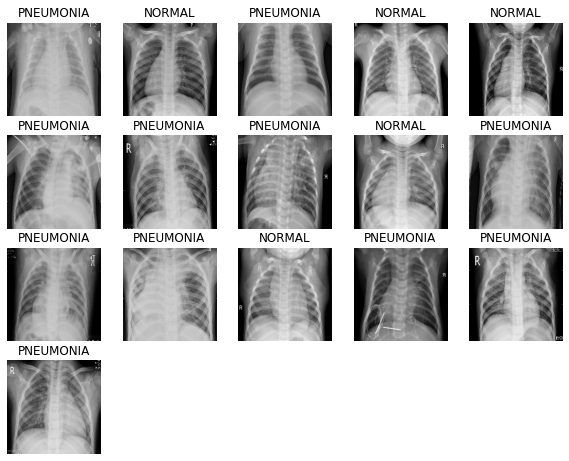

In [15]:
# for augmentation (좌우 반전)
image_batch, label_batch = next(iter(train_ds_t))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

In [16]:
def prepare_for_training(ds, shuffle_buffer_size=1000):

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

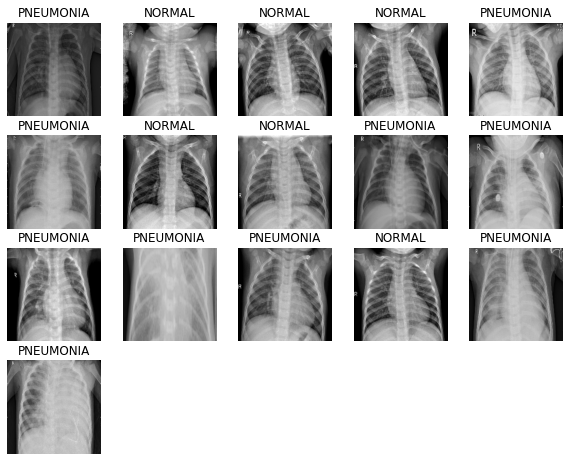

In [17]:
#  for original data
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

## Step 4. CNN 모델링

In [18]:
# modeling
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block


def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block


def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## Step 5. 데이터 imbalance 처리

In [19]:
# weight for imbalance data
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.93
Weight for class 1: 0.68


## Step 6. 모델 훈련

In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )


with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 35s 135ms/step - loss: 0.4008 - accuracy: 0.8022 - precision: 0.9478 - recall: 0.7755 - val_loss: 0.6249 - val_accuracy: 0.7529 - val_precision: 0.7529 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 28s 108ms/step - loss: 0.2382 - accuracy: 0.9083 - precision: 0.9675 - recall: 0.9065 - val_loss: 1.4279 - val_accuracy: 0.7500 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 32s 123ms/step - loss: 0.2100 - accuracy: 0.9234 - precision: 0.9753 - recall: 0.9198 - val_loss: 0.3073 - val_accuracy: 0.8625 - val_precision: 0.8451 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 28s 107ms/step - loss: 0.2052 - accuracy: 0.9210 - precision: 0.9742 - recall: 0.9174 - val_loss: 0.1247 - val_accuracy: 0.9548 - val_precision: 0.9933 - val_recall: 0.9460
Epoch 5/25
261/261 [==============================] - 27s 105ms/step - loss: 0.1659 - accura

## Step 7. 결과 확인과 시각화

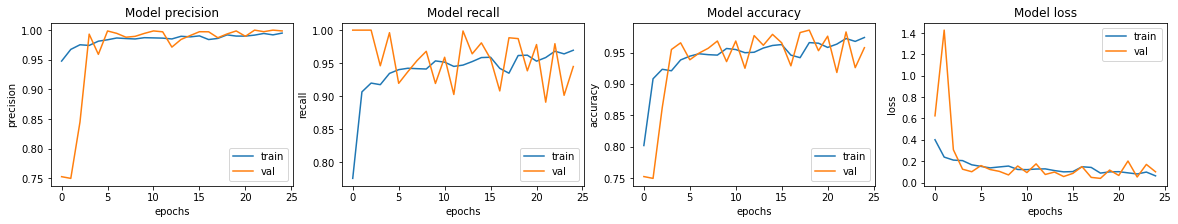

In [21]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [22]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 3s 70ms/step - loss: 0.8036 - accuracy: 0.8574 - precision: 0.8352 - recall: 0.9615


Another test (augmentation)

In [23]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )


with tf.device('/GPU:0'):
    history = model.fit(
        train_ds_t,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 31s 117ms/step - loss: 0.4138 - accuracy: 0.7845 - precision: 0.9434 - recall: 0.7544 - val_loss: 0.5674 - val_accuracy: 0.7500 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 29s 111ms/step - loss: 0.2395 - accuracy: 0.8997 - precision: 0.9694 - recall: 0.8926 - val_loss: 1.0609 - val_accuracy: 0.7481 - val_precision: 0.7481 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 29s 111ms/step - loss: 0.1965 - accuracy: 0.9260 - precision: 0.9764 - recall: 0.9223 - val_loss: 0.3857 - val_accuracy: 0.8250 - val_precision: 0.9983 - val_recall: 0.7677
Epoch 4/25
261/261 [==============================] - 30s 113ms/step - loss: 0.1740 - accuracy: 0.9325 - precision: 0.9815 - recall: 0.9262 - val_loss: 0.1165 - val_accuracy: 0.9567 - val_precision: 0.9906 - val_recall: 0.9512
Epoch 5/25
261/261 [==============================] - 29s 109ms/step - loss: 0.1675 - accura

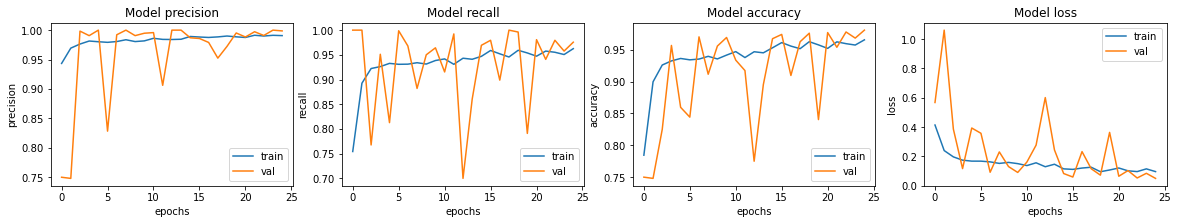

In [25]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [26]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 3s 78ms/step - loss: 0.9317 - accuracy: 0.8077 - precision: 0.7700 - recall: 0.9872


## 회고 및 루브릭 평가

### 루브릭 평가 항목
1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.(모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.)
2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.(regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.)
3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.(Accuracy 기준 85%에 도달하였다.)

### 평가 항목에 대한 수행
1. 마지막 그래프들을 보면 epoch에 따라 train에 대해서 성능 지표들이 좋은 값들로 수렴하는 것을 알 수 있다.
2. 같은 모델에 대해서 원래 데이터와 augmentation을 한 데이터로 학습하여 비교하는 실험을 하였다. 결과적으로 원래 데이터가 정확도에서는 5% 정도 더 높은 결과를 보여주었다.
3. 원래 데이터에 대하여 Accuracy가 85% 이상임을 알 수 있다.

### 회고

노션에 공지된 꼭 포함이 되어야 할 점
- 이번 프로젝트에서 **어려웠던 점,**
- 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
- 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.
- 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
- **자기 다짐**

---
- **어려웠던 점**    
예상과 달리 별 다른 코드의 수정 없이 목표치인 정확도 85%을 달성하여서 어려웠던 점이 없다.

---
- **알아낸 점**    
Augmentation을 한다고 무조건 성능이 좋아지는 것은 아니라는 것을 알 수 있었다. 그리고 imbalance data에 대해서 다룰 때에 weight를 주는 방법에 대해서 알 수 있었다. 그리고 폐렴에 대한 지식도 알 수 있었다.

- **모호한 점**    
Augmentation을 해서 성능이 오히려 낮아진 것을 보여주는 데 그렇다면 정확히 어떤 방법을 사용해야 성능이 올라가는 지에 대한 의문이 생긴다.

---
- **시도한 것들**   
Augmentation(좌우 반전)을 하고 원래 데이터와 성능을 비교하였다.

---
- **우브릭 평가 관련 지표**   
제 예상에는 모두 달성되었다고 생각한다. 그 이유는 위에 있는 **평가 항목에 대한 수행**에 나와있다.  
- **자기 다짐** 및 **나의 생각들**      
폐렴과 정상인 이미지를 살펴보면 명확히 눈으로 구분이 잘 되는 것도 있지만 잘 안 되는 것도 있어서 정확히 어떤 기준으로 분류하는 건 지를 잘 모르겠다. 그래서 데이터에 대해서 크게 다루는 것이 의미가 없었다. 그 이유는 데이터에 대한 이해가 부족하기 때문이다. 그래서 크게 변경할 수 없었고 좌우를 반전하는 정도의 augmentation을 사용한 것 같다. 데이터를 잘 이용하기 위해서는 역시 도메인에 대한 지식이 많이 필요하다는 것을 느꼈다. 